In [1]:
import json
import pandas as pd
import os
import time
import google.generativeai as genai
import seaborn as sns
from PIL import Image
from IPython.display import display, Image as IPImage
from dotenv import load_dotenv
from tqdm import tqdm

# 0) Import Data Sets

In [2]:
train_images_dir = os.path.join("2024_dataset", "images", "train")
val_images_dir = os.path.join("2024_dataset", "images", "valid")
test_images_dir = os.path.join("2024_dataset", "images", "test")

train_json_file = os.path.join("2024_dataset", "train_downloaded.json")
with open(train_json_file, 'r', encoding='utf-8') as f:
    train_data = json.load(f)

val_json_file = os.path.join("2024_dataset", "valid_downloaded.json")
with open(val_json_file, 'r', encoding='utf-8') as f:
    val_data = json.load(f)

test_json_file = os.path.join("2024_dataset", "test_downloaded.json")
with open(test_json_file, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

In [3]:
def filter_valid_entries(data, images_dir, verbose=False):
    valid_entries = []
    for entry in data:
        image_path = os.path.normpath(os.path.join(images_dir, f"{entry['encounter_id']}.jpg"))
        if os.path.exists(image_path):
            valid_entries.append(entry)
        elif verbose:
            print(f"Skipping entry with missing image: {entry['encounter_id']}")
    return valid_entries

In [4]:
train_valid_data = filter_valid_entries(train_data, train_images_dir)
val_valid_data = filter_valid_entries(val_data, val_images_dir)
test_valid_data = filter_valid_entries(test_data, test_images_dir)

# 1) Retrieve Captions + Images for Single Training Data Example

In [5]:
if train_valid_data:
    first_entry = train_valid_data[0]
    image_id = first_entry["encounter_id"]
    caption = first_entry["responses"][0]["content_en"]
    print(f"Image ID: {image_id}")
    print(f"Caption: {caption}")
else:
    print("The dataset is empty.")

Image ID: ih99w9
Caption: Most probably it is a case of inflamed pimple, may be due to folliculitis or acne. As it's beginning to disappear you can just wait and follow up if further changes occur. You can also try topical steroid cream for a few days if still inflamed.


In [6]:
data_combined = []

for entry in train_valid_data:
    jpg_path = os.path.join(train_images_dir, f"{entry['encounter_id']}.jpg")
    png_path = os.path.join(train_images_dir, f"{entry['encounter_id']}.png")

    if os.path.exists(jpg_path):
        image_path = jpg_path
    elif os.path.exists(png_path):
        image_path = png_path
    else:
        continue

    data_combined.append({
        "image_path": image_path,
        "caption": entry["responses"][0]["content_en"],
        # "query": entry["query_title_en"]
        "query": f"{entry.get('query_title_en', '')} {entry.get('query_content_en', '')}".strip()
    })

df = pd.DataFrame(data_combined)
display(df.head())
print(len(df))

,image_path,caption,query
0,2024_dataset\images\train\ih99w9.jpg,"Most probably it is a case of inflamed pimple,...",I had this mole that appeared under my eye abo...
1,2024_dataset\images\train\11n62qx.jpg,"Most probably it is a case of solar lentigo, a...",Spot in my hairline
2,2024_dataset\images\train\vk578x.jpg,Most propably it is a case of a cyst in the gr...,Can someone help me ID this random bump? Today...
3,2024_dataset\images\train\123bko0.jpg,It is a case of common wart. This noncancerous...,Rough bump/spot on the side of finger? What ex...
4,2024_dataset\images\train\11m0l9c.jpg,Most probably it is a case of deep coarse wrin...,Puffy line on face any suggestions?


213


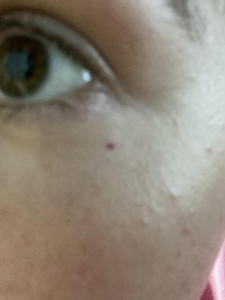

Query: I had this mole that appeared under my eye about 4-5 days ago, and now it’s starting to disappear. The picture I’m showing was taken Friday, I would show you what the “mole” looks like right now but honestly I don’t know how to show two pictures on reddit.
Caption: Most probably it is a case of inflamed pimple, may be due to folliculitis or acne. As it's beginning to disappear you can just wait and follow up if further changes occur. You can also try topical steroid cream for a few days if still inflamed.


In [7]:
first_row = df.iloc[0]
image_path = first_row["image_path"]
caption = first_row["caption"]
query = first_row["query"]

img = Image.open(image_path)
img.thumbnail((300, 300))
display(img)

print(f"Query: {query}")
print(f"Caption: {caption}")

# 2) Pass it through an initial baseline architecture

<img src="image.png" alt="image.png" width="300"/>

In [8]:
# Step 1: Load environment variables and configure Gemini
load_dotenv()
api_key = os.getenv('API_KEY')
genai.configure(api_key=api_key)
model_name = 'gemini-1.5-flash'
model = genai.GenerativeModel(model_name)

In [9]:
# Step 2: Define a function to process the image with Gemini
def process_image_with_gemini(image_path, model):
    image_prompt = f"""
    Describe the following image in detail for a medical context.
    Provide a comprehensive description including any visible abnormalities, patterns, or other notable observations.
    Output the description in plain text without any additional formatting.
    """

    response = model.generate_content([image_prompt, Image.open(image_path)])
    return response.text.strip()

In [11]:
gemini_description = process_image_with_gemini(image_path, model)

In [12]:
# Print the query, caption, and Gemini description
print(f"Query: {query}")
print(f"Caption: {caption}")
print(f"Gemini Description: {gemini_description}")

Query: I had this mole that appeared under my eye about 4-5 days ago, and now it’s starting to disappear. The picture I’m showing was taken Friday, I would show you what the “mole” looks like right now but honestly I don’t know how to show two pictures on reddit.
Caption: Most probably it is a case of inflamed pimple, may be due to folliculitis or acne. As it's beginning to disappear you can just wait and follow up if further changes occur. You can also try topical steroid cream for a few days if still inflamed.
Gemini Description: The image shows a close-up view of a person's face, specifically the area around the eye and cheek.  The skin appears to have a slightly uneven texture with multiple small, slightly raised, possibly papular lesions scattered across the cheek.  There is also a small, dark reddish-purple macule visible on the cheek. The overall skin tone is light to medium. The image quality is somewhat blurry, making precise assessment of lesion characteristics difficult.  Th

In [14]:
# Step 3: Generate the response from the original model
def generate_response(query, image_description, model):
    response_prompt = f"""
    Based on the following query and image description, provide a detailed and helpful medical response:

    Query: {query}
    Image Description: {image_description}

    Output the response in plain text without any additional formatting.
    """
    response = model.generate_content(response_prompt)
    return response.text.strip()

In [15]:
generated_response = generate_response(query, gemini_description, model)

In [16]:
# Print the query, caption, Gemini description, and generated response
print(f"Query: {query}")
print(f"Caption: {caption}")
print(f"Gemini Description: {gemini_description}")
print(f"Generated Response: {generated_response}")

Query: I had this mole that appeared under my eye about 4-5 days ago, and now it’s starting to disappear. The picture I’m showing was taken Friday, I would show you what the “mole” looks like right now but honestly I don’t know how to show two pictures on reddit.
Caption: Most probably it is a case of inflamed pimple, may be due to folliculitis or acne. As it's beginning to disappear you can just wait and follow up if further changes occur. You can also try topical steroid cream for a few days if still inflamed.
Gemini Description: The image shows a close-up view of a person's face, specifically the area around the eye and cheek.  The skin appears to have a slightly uneven texture with multiple small, slightly raised, possibly papular lesions scattered across the cheek.  There is also a small, dark reddish-purple macule visible on the cheek. The overall skin tone is light to medium. The image quality is somewhat blurry, making precise assessment of lesion characteristics difficult.  Th

In [27]:
# Select the first entry from the validation dataset
if val_valid_data:
    first_val_entry = val_valid_data[0]
    val_image_path = os.path.join(val_images_dir, f"{first_val_entry['encounter_id']}.jpg")
    if not os.path.exists(val_image_path):
        val_image_path = os.path.join(val_images_dir, f"{first_val_entry['encounter_id']}.png")
    
    # val_query = first_val_entry["query_title_en"]
    val_query = f"{first_val_entry.get('query_title_en', '')} {first_val_entry.get('query_content_en', '')}".strip()
    val_caption = first_val_entry["responses"][0]["content_en"]

    # Process the validation image with the original Gemini model
    val_gemini_description = process_image_with_gemini(val_image_path, model)

    # Generate a response using the fine-tuned model
    val_generated_response = generate_response(val_query, val_gemini_description, model)

    # Print results
    print(f"Query: {val_query}")
    print(f"Caption: {val_caption}")
    print(f"Gemini Description: {val_gemini_description}")
    print(f"Generated Response: {val_generated_response}")
else:
    print("Validation dataset is empty.")

Query: Why do I have this raised horizontal skin/bump? on my forearm
Caption: Some group of people has a genetic predisposition to these lines. It is more common in the dominant arm. Research studies are limited on this condition but the more fat that you carry on your arms, the more likely creases are to form on your skin. If you don’t want this crease, then first lose some body fat to rule out that cause. If the crease still persists, then you’ll know that they’re a permanent fixture on your arms due to your genetics. If they’re not causing you any pain or if they don’t look too abnormal for your liking , then you don't need to worry about them
Gemini Description: The image shows a close-up view of a section of light-toned skin, appearing to be on a leg or arm, with fine, light-colored hair sparsely distributed across the surface.  There is a subtle, faintly visible linear mark or crease running horizontally across a portion of the skin. The skin itself appears relatively smooth with

# 3) Process Entire Dataset

Processing val dataset...


Processing val dataset:  74%|███████▍  | 26/35 [16:39<29:38, 197.62s/it]

Skipping due to Gemini error: Timeout of 600.0s exceeded, last exception: 503 The service is currently unavailable.


Processing val dataset: 100%|██████████| 35/35 [22:30<00:00, 38.57s/it] 


Final save completed for val dataset.
Completed processing val dataset. 34 entries processed.
Processing test dataset...


Processing test dataset:  78%|███████▊  | 50/64 [07:52<01:03,  4.55s/it]

Saved progress at 50 entries.


Processing test dataset: 100%|██████████| 64/64 [08:54<00:00,  8.35s/it]

Final save completed for test dataset.
Completed processing test dataset. 64 entries processed.


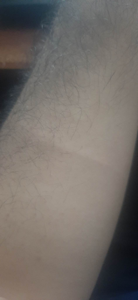

Query: Why do I have this raised horizontal skin/bump? on my forearm

Original Caption: Some group of people has a genetic predisposition to these lines. It is more common in the dominant arm. Research studies are limited on this condition but the more fat that you carry on your arms, the more likely creases are to form on your skin. If you don’t want this crease, then first lose some body fat to rule out that cause. If the crease still persists, then you’ll know that they’re a permanent fixture on your arms due to your genetics. If they’re not causing you any pain or if they don’t look too abnormal for your liking , then you don't need to worry about them

Gemini Image Description: The image shows a close-up view of light-toned skin with sparse, fine, light-colored hair.  There is a faintly visible, linear, slightly depressed area on the skin, which appears to be a shallow scar or crease.  No other lesions or abnormalities are readily apparent. The lighting and image quality are somew

In [29]:
def process_entry(entry, images_dir, model):
    image_path = os.path.normpath(os.path.join(images_dir, f"{entry['encounter_id']}.jpg"))
    
    if not os.path.exists(image_path):
        return None 

    # query = entry.get("query_title_en", "No query provided.")
    query = f"{entry.get('query_title_en', '')} {entry.get('query_content_en', '')}".strip()
    original_caption = entry["responses"][0]["content_en"]

    try:
        image_description = process_image_with_gemini(image_path, model)
    except Exception as e:
        print(f"Skipping due to Gemini error: {e}")
        return None

    try:
        response = generate_response(query, image_description, model)
    except Exception as e:
        print(f"Skipping due to model error: {e}")
        return None

    return {
        "image_path": image_path,
        "query": query,
        "original_caption": original_caption,
        "image_description": image_description,
        "response": response,
    }

def process_dataset(data, images_dir, model, dataset_name, save_every=50):
    results = []

    output_dir = os.path.join("2024_dataset", "results")
    os.makedirs(output_dir, exist_ok=True)
    
    output_file = os.path.join(output_dir, f"processed_{dataset_name}_data.csv")

    # output_file = f"processed_{dataset_name}_data.csv"
    
    if os.path.exists(output_file):
        processed_df = pd.read_csv(output_file)
        processed_encounters = set(processed_df["image_path"])
        print(f"Resuming from saved progress: {len(processed_encounters)} entries loaded.")
    else:
        processed_encounters = set()
        processed_df = pd.DataFrame()

    for i, entry in tqdm(enumerate(data, start=1), total=len(data), desc=f"Processing {dataset_name} dataset"):
        if os.path.join(images_dir, f"{entry['encounter_id']}.jpg") in processed_encounters:
            continue

        result = process_entry(entry, images_dir, model)
        if result:
            results.append(result)

        if i % save_every == 0:
            df = pd.DataFrame(results)
            processed_df = pd.concat([processed_df, df], ignore_index=True)
            processed_df.to_csv(output_file, index=False)
            print(f"Saved progress at {i} entries.")
            results = []

    df = pd.DataFrame(results)
    processed_df = pd.concat([processed_df, df], ignore_index=True)
    processed_df.to_csv(output_file, index=False)
    print(f"Final save completed for {dataset_name} dataset.")

    return processed_df

datasets = {
    # "train": (train_valid_data, train_images_dir),
    "val": (val_valid_data, val_images_dir),
    "test": (test_valid_data, test_images_dir),
}

processed_dfs = {}

for dataset_name, (data, img_dir) in datasets.items():
    if data:
        print(f"Processing {dataset_name} dataset...")
        processed_dfs[dataset_name] = process_dataset(data, img_dir, model, dataset_name)
        print(f"Completed processing {dataset_name} dataset. {len(processed_dfs[dataset_name])} entries processed.")
    else:
        print(f"No valid entries found for {dataset_name} dataset.")

def display_example(row):
    img = Image.open(row["image_path"])
    img.thumbnail((300, 300))
    display(img)

    print(f"Query: {row['query']}\n")
    print(f"Original Caption: {row['original_caption']}\n")
    print(f"Gemini Image Description: {row['image_description']}\n")
    print(f"Generated Response: {row['response']}\n")

if "val" in processed_dfs and not processed_dfs["val"].empty:
    display_example(processed_dfs["val"].iloc[0])

In [ ]:
# Need to run the below with retry logic for the entire dataset + incorporate this into other pipelines

def process_entry(entry, images_dir, model, max_retries=3):
    image_path = os.path.normpath(os.path.join(images_dir, f"{entry['encounter_id']}.jpg"))
    
    if not os.path.exists(image_path):
        return None 

    query = f"{entry.get('query_title_en', '')} {entry.get('query_content_en', '')}".strip()
    original_caption = entry["responses"][0]["content_en"]

    for attempt in range(1, max_retries + 1):
        try:
            image_description = process_image_with_gemini(image_path, model)
            break
        except Exception as e:
            print(f"Attempt {attempt}/{max_retries} - Gemini error: {e}")
            if attempt == max_retries:
                print(f"Skipping due to repeated Gemini errors: {e}")
                return None
            time.sleep(2 ** attempt)

    for attempt in range(1, max_retries + 1):
        try:
            response = generate_response(query, image_description, model)
            break
        except Exception as e:
            print(f"Attempt {attempt}/{max_retries} - Model error: {e}")
            if attempt == max_retries:
                print(f"Skipping due to repeated model errors: {e}")
                return None
            time.sleep(2 ** attempt)

    return {
        "image_path": image_path,
        "query": query,
        "original_caption": original_caption,
        "image_description": image_description,
        "response": response,
    }

def process_dataset(data, images_dir, model, dataset_name, save_every=50):
    results = []
    failed_entries = []
    
    output_dir = os.path.join("2024_dataset", "results")
    os.makedirs(output_dir, exist_ok=True)
    
    output_file = os.path.join(output_dir, f"processed_{dataset_name}_data.csv")

    if os.path.exists(output_file):
        processed_df = pd.read_csv(output_file)
        processed_encounters = set(processed_df["image_path"])
        print(f"Resuming from saved progress: {len(processed_encounters)} entries loaded.")
    else:
        processed_encounters = set()
        processed_df = pd.DataFrame()

    for i, entry in tqdm(enumerate(data, start=1), total=len(data), desc=f"Processing {dataset_name} dataset"):
        if os.path.join(images_dir, f"{entry['encounter_id']}.jpg") in processed_encounters:
            continue

        result = process_entry(entry, images_dir, model)
        if result:
            results.append(result)
        else:
            failed_entries.append(entry)

        if i % save_every == 0:
            df = pd.DataFrame(results)
            processed_df = pd.concat([processed_df, df], ignore_index=True)
            processed_df.to_csv(output_file, index=False)
            print(f"Saved progress at {i} entries.")
            results = []

    df = pd.DataFrame(results)
    processed_df = pd.concat([processed_df, df], ignore_index=True)
    processed_df.to_csv(output_file, index=False)

    print(f"Retrying {len(failed_entries)} failed entries...")
    retried_results = []
    for entry in failed_entries:
        result = process_entry(entry, images_dir, model)
        if result:
            retried_results.append(result)

    if retried_results:
        df = pd.DataFrame(retried_results)
        processed_df = pd.concat([processed_df, df], ignore_index=True)
        processed_df.to_csv(output_file, index=False)
        print(f"Final retry save completed for {dataset_name} dataset.")

    print(f"Final save completed for {dataset_name} dataset.")
    return processed_df

datasets = {
    # "train": (train_valid_data, train_images_dir),
    "val": (val_valid_data, val_images_dir),
    "test": (test_valid_data, test_images_dir),
}

processed_dfs = {}

for dataset_name, (data, img_dir) in datasets.items():
    if data:
        print(f"Processing {dataset_name} dataset...")
        processed_dfs[dataset_name] = process_dataset(data, img_dir, model, dataset_name)
        print(f"Completed processing {dataset_name} dataset. {len(processed_dfs[dataset_name])} entries processed.")
    else:
        print(f"No valid entries found for {dataset_name} dataset.")

def display_example(row):
    img = Image.open(row["image_path"])
    img.thumbnail((300, 300))
    display(img)

    print(f"Query: {row['query']}\n")
    print(f"Original Caption: {row['original_caption']}\n")
    print(f"Gemini Image Description: {row['image_description']}\n")
    print(f"Generated Response: {row['response']}\n")

if "val" in processed_dfs and not processed_dfs["val"].empty:
    display_example(processed_dfs["val"].iloc[0])